In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings('ignore')
sns.set_context("talk")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s3e9/sample_submission.csv')
extra = pd.read_csv('/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv')
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)
extra = extra.rename(columns = {'CementComponent ':'CementComponent'})

In [3]:
train.isna().sum()

CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64

In [4]:
test.isna().sum()

CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
dtype: int64

In [5]:
extra.isna().sum()

CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64

In [6]:
df = pd.concat([train,extra])
df.drop_duplicates(inplace=True)

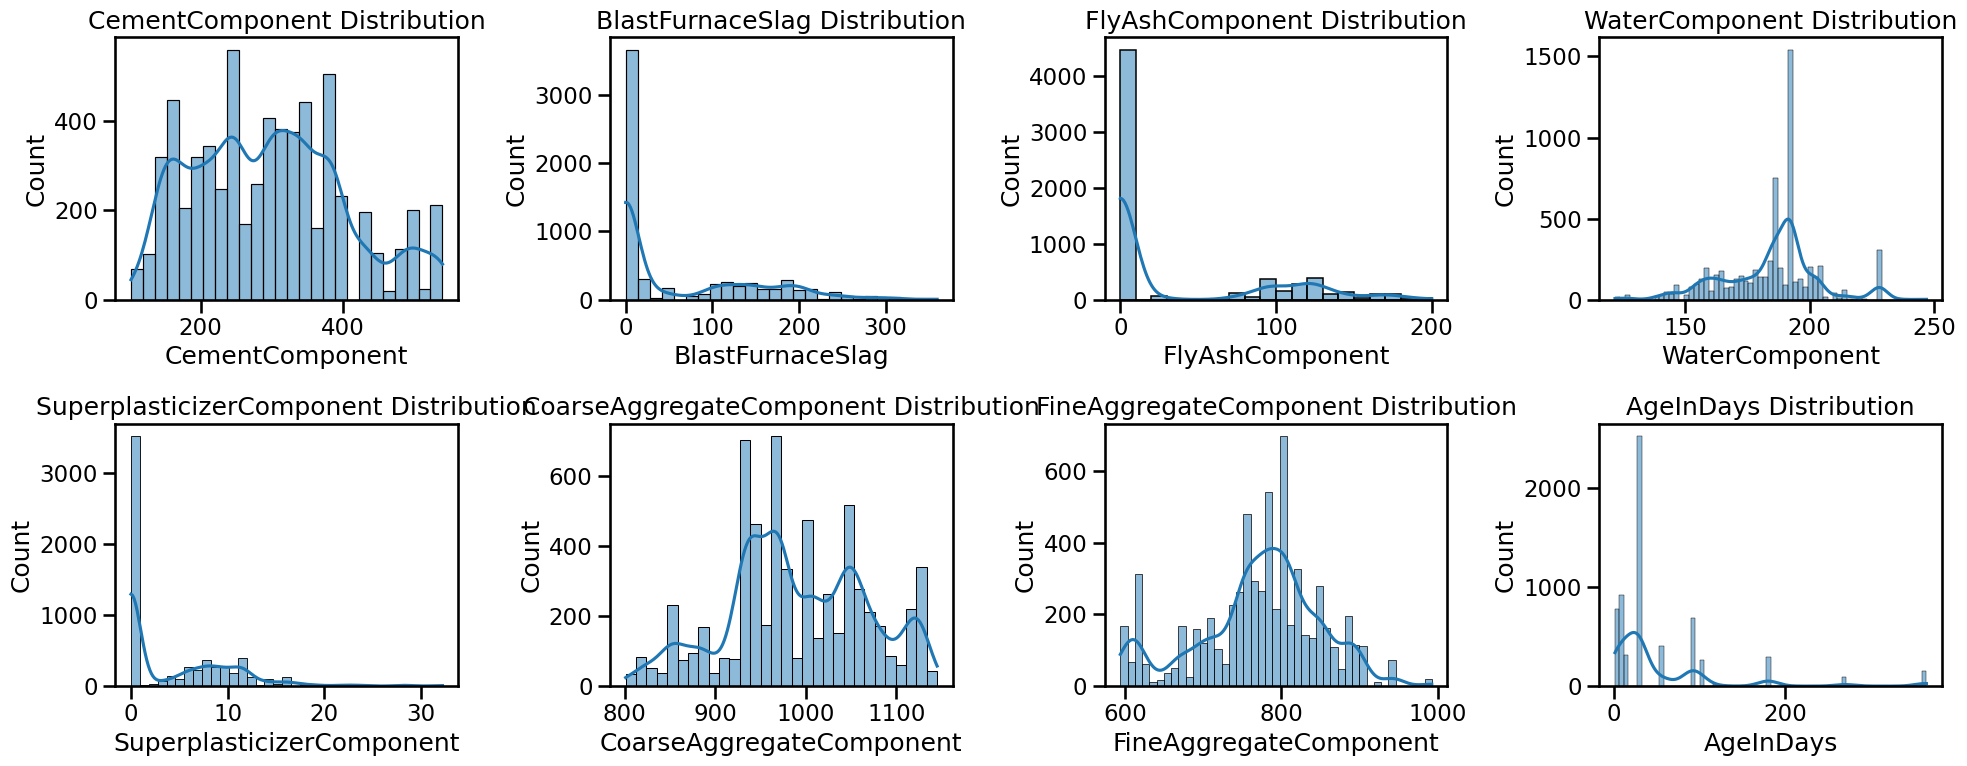

In [7]:
num_cols = test.columns.to_list()

def histograms_plot(dataframe, features, rows, cols): 
    fig=plt.figure(figsize=(20,8))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        sns.histplot(x=dataframe[feature], fill=True, data=df, kde=True)
        ax.set_title(feature+" Distribution",color='black')
    fig.tight_layout()  
    plt.show()

histograms_plot(df,num_cols,2,4)

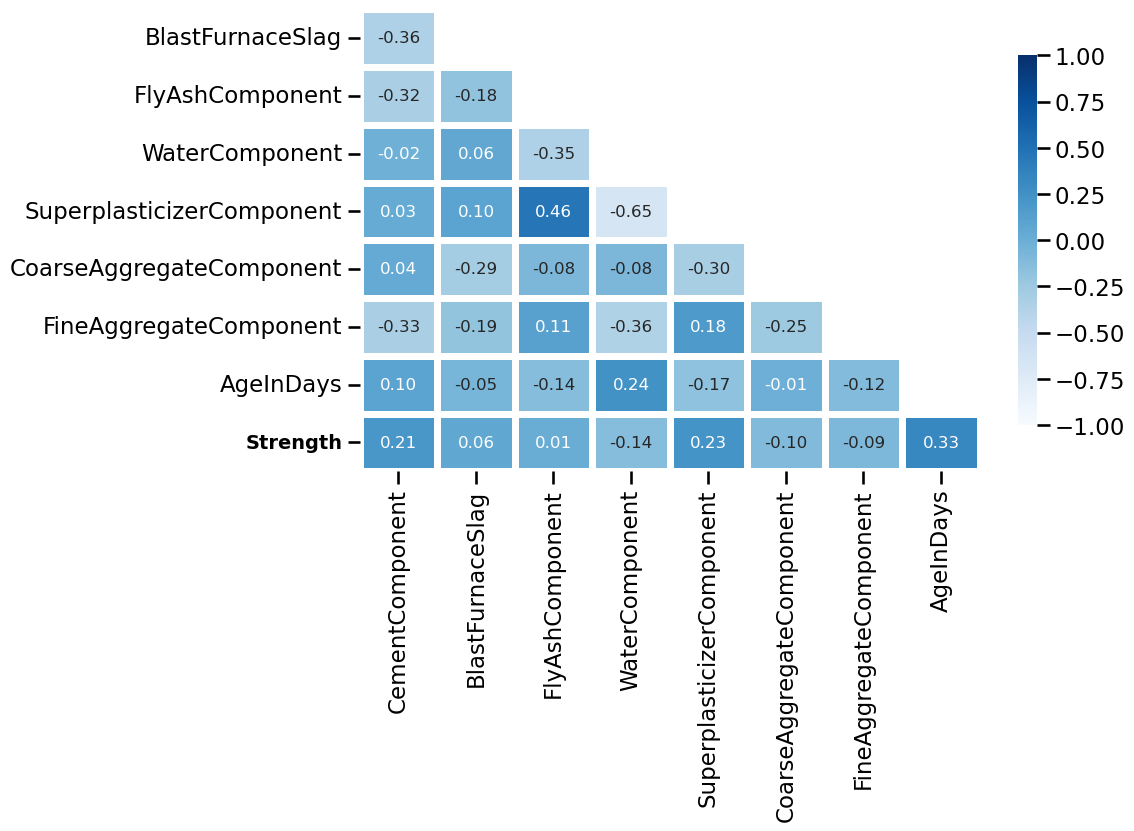

In [8]:
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 6))
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
sns.heatmap(corr, mask=mask, fmt=".2f", cmap='Blues',vmin=-1, vmax=1, annot=True, annot_kws={'fontsize': 12}, cbar_kws={"shrink": .8}, linewidths=5,)
plt.yticks(rotation=0)
plt.yticks()[-1][-1].set_fontsize(14)
plt.yticks()[-1][-1].set_fontweight('bold')
plt.show()

In [9]:
df = pd.concat([df,test])

In [10]:
scaler = RobustScaler()

y = df['Strength']
df = df.drop(['Strength'], axis=1)

df[df.columns] = scaler.fit_transform(df[df.columns])

In [11]:
train_df = df.iloc[:-len(test),:]
train_df['Strength'] = y[:-len(test)]
test_df = df.iloc[-len(test):,:].reset_index(drop=True)

X = train_df.drop(['Strength'], axis=1)
y = train_df.Strength.astype('int')
X_test = test_df

In [12]:
k_fold = StratifiedKFold(n_splits=10, random_state=2023, shuffle=True)

def train_model(X,y,modelo):
    vl = []
    for train_index, test_index in k_fold.split(X, y):        
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
        mod = modelo()
        mod.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
        mod_preds = mod.predict(X_valid)
        mod_test_preds = mod.predict(X_test)
        vl.append(mse(y_valid, mod_preds))
    dic = {'model':str(modelo), 'result':round(np.mean(vl),4)}
    return dic, mod

In [13]:
df_result = pd.DataFrame(columns=['model','result'])

dic, xgb_cla = train_model(X,y,XGBRegressor)
df_result = df_result.append(dic, ignore_index=True)

dic, lgc_cla = train_model(X,y,LGBMRegressor)
df_result = df_result.append(dic, ignore_index=True)

dic, cat_cla = train_model(X,y,CatBoostRegressor)
df_result = df_result.append(dic, ignore_index=True)

In [14]:
df_result

,model,result
0,<class 'xgboost.sklearn.XGBRegressor'>,149.7077
1,<class 'lightgbm.sklearn.LGBMRegressor'>,140.3710
2,<class 'catboost.core.CatBoostRegressor'>,134.7508


In [15]:
sub['Strength'] = cat_cla.predict(X_test)
sub.to_csv('submission.csv',index=False)